<div style="background-color: #f8f9fa; padding: 20px;">
    <h1 style="color: #007bff; font-size: 32px; margin-bottom: 10px;">Computer Vision Project</h1>
    <div style="color: #495057; font-size: 14px; margin-bottom: 5px;">by</div>
    <div style="color: #343a40; font-size: 20px; margin-bottom: 15px;">Prashant Patil</div>
    <div style="color: #6c757d; font-size: 14px;">AIML Online October 2023-A Batch</div>
    <div style="color: #6c757d; font-size: 14px;">21 Jul 2024</div>
</div>

# Table of Contents

* Import libraries

### Part A
* Data Reading from Images.npy
* Capture data into X (Images) and y (masks data). Draw face rectangle for sample image.
* Train test split
* Display original, processed and masked image
* Design model, dice coefficient, loss
* Model fit (Training data)
* Model tuning (Training data)
* Model evaluation (for both models) with testing data
* Test Model on one of the image at index#3

### Part B
* Read images data from training_images
* Detect faces for all images
* Display few images with rectangle for faces
* Save face metadata into dataframe
* Save metadata into csv file

### Part C
* Unzip data and load into variable
* Extract metadata
* Embedding vectors : design and usage
* Test embeddign vectors using distance
* PCA : dimensionality reduction
* SVM : Model building for prediction
* Display test images
* Predict face names for given images

# Part A

In [255]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D, Dropout, BatchNormalization, ReLU
from sklearn.model_selection import train_test_split
from PIL import Image , ImageDraw
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Q.1. Import and Understand the data

### Q.1.A. Import and read ‘images.npy’.

In [196]:
images = np.load('/content/drive/My Drive/Colab/CV/Images.npy', allow_pickle=True)
# images = np.load('C:/Users/prash/GL-AI-ML/Computer Vision/Project/Project files/Images.npy', allow_pickle=True)
print('Shape of images array:', images.shape)

Shape of images array: (393, 2)


##### Draw face rectangle for sample image

Label: ['Face']
Top-left corner: (0.086, 0.306)
Bottom-right corner: (0.172, 0.453)
Image dimensions: 650 x 333
Label: ['Face']
Top-left corner: (0.583, 0.291)
Bottom-right corner: (0.658, 0.468)
Image dimensions: 650 x 333
Image 1: [{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


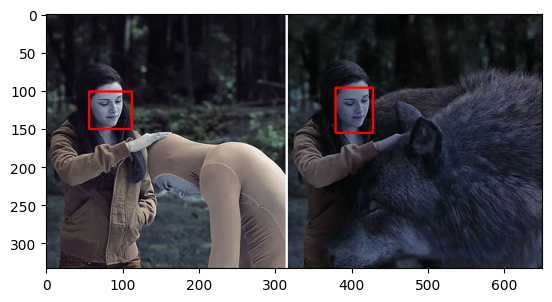

In [197]:
#Lets now try detecting face on one of the image
for i in range(1):
    # Extract the image and label
    image = images[i][0]
    label = images[i][1]

    image_cv2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Iterate through the list of face dictionaries (if multiple faces are present)
    for face_dict in label:

        face_label = face_dict.get('label', 'Unknown')

        # Extract points (coordinates)
        points = face_dict.get('points', [])
        top_left = points[0] if len(points) >= 1 else None
        bottom_right = points[1] if len(points) >= 2 else None

        # Extract image dimensions
        image_width = face_dict.get('imageWidth', 0)
        image_height = face_dict.get('imageHeight', 0)

        # Print extracted information
        print(f"Label: {face_label}")
        print(f"Top-left corner: ({top_left['x']:.3f}, {top_left['y']:.3f})")
        print(f"Bottom-right corner: ({bottom_right['x']:.3f}, {bottom_right['y']:.3f})")
        print(f"Image dimensions: {image_width} x {image_height}")

        x1 = int(top_left['x'] * image_width) # Convert coordinates to integers
        y1 = int(top_left['y'] * image_height)
        x2 = int(bottom_right['x'] * image_width)
        y2 = int(bottom_right['y'] * image_height)

        # Convert the image data to uint8 format
        image = image.astype(np.uint8)

        # Create an OpenCV image object
        cv2.rectangle(image_cv2,(x1,y1),(x2,y2),(255,0,0), 2)

    # Print the label
    print(f"Image {i+1}: {label}")

    # Display the image
    plt.imshow(image_cv2)
    plt.show()

### Q.1.B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

* Features (X) will be image data.
* Labels(Y) will be masked data.

We need to run loop to read images and store image data in X and mask data into Y.

In [198]:
IMAGE_HEIGHT = 224  # Example value
IMAGE_WIDTH = 224   # Example value

masks = np.zeros((int(images.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = []
resized_images = []

for index in range(images.shape[0]):
    img = images[index][0]
    # *************Unify shape of all the images.****************
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    # ***********************************************************
    if len(img.shape) == 2:  # Grayscale
        img = np.stack((img,)*3, axis=-1)  # Convert to RGB
    elif img.shape[2] == 4:  # RGBA
        img = img[:,:,:3]  # Extract only the RGB channels
    # try:
    #     img = img[:, :, :3]
    # except:
    #     continue
    X.append(img)
    # resized_images.append((img))
    for i in images[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

Assign masks into y and print shapes

In [199]:
#Lets assign masks data to Y
y = masks
print('X:', np.array(X).shape)
print('y:',y.shape)

X: (393, 224, 224, 3)
y: (393, 224, 224)


### Q.1.C. Split the data into train and test (70:30 ratio)

In [200]:
# Split the data into train and test sets (70:30 ratio)
X_trainOG, X_testOG, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# OG: Original image before preprocessing

#Lets preprocess X data
X_train = preprocess_input(np.array(X_trainOG, dtype=np.float32))
X_test = preprocess_input(np.array(X_testOG, dtype=np.float32))

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (275, 224, 224, 3)
X_test shape: (118, 224, 224, 3)
y_train shape: (275, 224, 224)
y_test shape: (118, 224, 224)


### Q.1.D. Select random image from the train data and display original image and masked image.

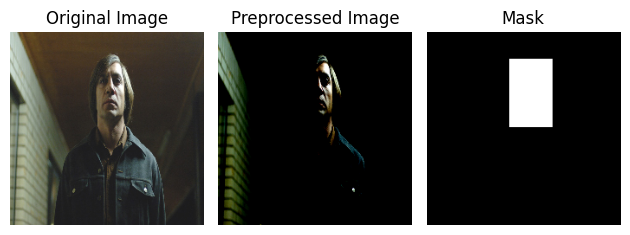

In [201]:
#Lets use randint for picking random index
random_index = np.random.randint(0, len(X_train))

# Fetch the image and mask using the random index
imageOG= X_trainOG[random_index]
image = X_train[random_index]
maskT = y_train[random_index]


# Plotting
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

# Plot original image
ax1.imshow(imageOG)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(image)
ax2.set_title('Preprocessed Image')
ax2.axis('off')

# Plot corresponding mask
ax3.imshow(maskT, cmap='gray')  # Assuming masks are binary (0 and 1)
ax3.set_title('Mask')
ax3.axis('off')

plt.tight_layout()
plt.show()

## Q.2. Model building

### Q.2.A. Design a face mask detection model.
Hint: 1. Use MobileNet architecture for initial pre-trained non-trainable layers.

Hint: 2. Add appropriate Upsampling layers to imitate U-net architecture

#####  Basic Model

In [202]:
#Lets create a function for designing model using MobileNet
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = False #Lets start by keeping trainable false

    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    # Upsample and concatenate with corresponding lower layers (skip connections)
    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)

    x = UpSampling2D()(x)
    print(x.shape)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)


In [203]:
model = create_model()

(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


In [204]:
#display model design
model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_33[0][0]']            
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']     

###. Q.2.B. Design your own Dice Coefficient and Loss function

In [205]:
#Function to get dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#Function to get dice loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

### Q.2.C. Train and tune the model as required

In [206]:
#Compile basic model using Adam
model.compile(loss=dice_loss, optimizer=Adam(learning_rate=0.0001), metrics=[dice_coefficient])

In [207]:
#Train basic model using training data
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=1
    # ,validation_data=(X_test, y_test)
)

Epoch 1/10
275/275 [==============================] - 6s 17ms/step - loss: 0.7843 - dice_coefficient: 0.2157
Epoch 2/10
275/275 [==============================] - 5s 17ms/step - loss: 0.5900 - dice_coefficient: 0.4100
Epoch 3/10
275/275 [==============================] - 5s 17ms/step - loss: 0.4938 - dice_coefficient: 0.5062
Epoch 4/10
275/275 [==============================] - 5s 17ms/step - loss: 0.4603 - dice_coefficient: 0.5397
Epoch 5/10
275/275 [==============================] - 5s 17ms/step - loss: 0.4425 - dice_coefficient: 0.5575
Epoch 6/10
275/275 [==============================] - 5s 16ms/step - loss: 0.4281 - dice_coefficient: 0.5719
Epoch 7/10
275/275 [==============================] - 5s 16ms/step - loss: 0.4177 - dice_coefficient: 0.5823
Epoch 8/10
275/275 [==============================] - 5s 17ms/step - loss: 0.4108 - dice_coefficient: 0.5892
Epoch 9/10
275/275 [==============================] - 5s 16ms/step - loss: 0.4039 - dice_coefficient: 0.5961
Epoch 10/10
275/275

#### Model Tuning

##### Tuned Model#1

- Change architecture
- Make layers trainable
- Batchnormalization
- Dropout
- Learning rate

In [208]:
import tensorflow as tf
def create_Tunedmodel(trainable):
  """
  Objective:  Creates a face mask detection model using MobileNet architecture, Upsampling layers, and Dropout.
  Returns:    A compiled Keras model for face mask detection.
  """

  model =  tf.keras.applications.MobileNet(input_shape=(224, 224, 3), include_top=False,alpha=1.0, weights="imagenet")

  for layer in model.layers:
      layer.trainable = trainable
  inputs = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

  # Extract features from MobileNet
  x = model(inputs)

  # Upsampling layers for U-net architecture with Dropout
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(512, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.1)(x)  # Add Dropout

  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.1)(x)  # Add Dropout

  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.1)(x)  # Add Dropout

  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.1)(x)  # Add Dropout

  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.1)(x)  # Add Dropout

  # Output layer with sigmoid activation
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

  # Create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# Create the face mask detection model with dropout
modelTuned = create_Tunedmodel(True)

# Print the model summary
modelTuned.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 up_sampling2d_122 (UpSampl  (None, 14, 14, 1024)      0         
 ing2D)                                                          
                                                                 
 conv2d_111 (Conv2D)         (None, 14, 14, 512)       4719104   
                                                                 
 batch_normalization_71 (Ba  (None, 14, 14, 512)       2048      
 tchNormalization)                                               
                                                          

In [209]:
#Train tuned model using training data
from tensorflow.keras.optimizers import Adam
modelTuned.compile(loss=dice_loss, optimizer=Adam(learning_rate=0.0001), metrics=[dice_coefficient])
history = modelTuned.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=1
)

Epoch 1/10
275/275 [==============================] - 18s 18ms/step - loss: 0.6133 - dice_coefficient: 0.3867
Epoch 2/10
275/275 [==============================] - 5s 19ms/step - loss: 0.5155 - dice_coefficient: 0.4845
Epoch 3/10
275/275 [==============================] - 5s 18ms/step - loss: 0.4418 - dice_coefficient: 0.5582
Epoch 4/10
275/275 [==============================] - 5s 19ms/step - loss: 0.3787 - dice_coefficient: 0.6213
Epoch 5/10
275/275 [==============================] - 5s 19ms/step - loss: 0.3273 - dice_coefficient: 0.6727
Epoch 6/10
275/275 [==============================] - 5s 18ms/step - loss: 0.2863 - dice_coefficient: 0.7137
Epoch 7/10
275/275 [==============================] - 5s 19ms/step - loss: 0.2479 - dice_coefficient: 0.7521
Epoch 8/10
275/275 [==============================] - 5s 18ms/step - loss: 0.2176 - dice_coefficient: 0.7824
Epoch 9/10
275/275 [==============================] - 5s 19ms/step - loss: 0.1997 - dice_coefficient: 0.8003
Epoch 10/10
275/27

##### Tuned Model#2

- Change architecture
- Batch normalization

In [210]:
#Lets create a function for designing model using MobileNet
def create_Tunedmodel2(trainable,IMAGE_HEIGHT, IMAGE_WIDTH):
    # Load MobileNet model with pre-trained weights
    base_model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    # Freeze the layers of MobileNet
    for layer in base_model.layers:
        layer.trainable = trainable

    # Extract intermediate layers to form skip connections
    block0 = base_model.get_layer("conv_pw_1_relu").output
    block1 = base_model.get_layer("conv_pw_3_relu").output
    block2 = base_model.get_layer("conv_pw_5_relu").output
    block3 = base_model.get_layer("conv_pw_11_relu").output
    block4 = base_model.get_layer("conv_pw_13_relu").output

    # Upsample and concatenate with corresponding lower layers (skip connections)
    x = UpSampling2D()(block4)
    x = Concatenate()([x, block3])
    x = Conv2D(512, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D()(x)
    x = Concatenate()([x, block2])
    x = Conv2D(256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D()(x)
    x = Concatenate()([x, block1])
    x = Conv2D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D()(x)
    x = Concatenate()([x, block0])
    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Final upsampling and convolution layers
    x = UpSampling2D()(x)
    x = Conv2D(32, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=x)

    return model


modelTuned2 = create_Tunedmodel2(False,IMAGE_HEIGHT, IMAGE_WIDTH)
modelTuned2.summary()


Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_36[0][0]']            
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']     

In [211]:
modelTuned2.compile(loss=dice_loss, optimizer=Adam(learning_rate=0.0001), metrics=[dice_coefficient])
history = modelTuned2.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=1
    # ,validation_data=(X_test, y_test)
)

Epoch 1/10
275/275 [==============================] - 7s 10ms/step - loss: 0.6166 - dice_coefficient: 0.3834
Epoch 2/10
275/275 [==============================] - 3s 9ms/step - loss: 0.5508 - dice_coefficient: 0.4492
Epoch 3/10
275/275 [==============================] - 3s 9ms/step - loss: 0.4962 - dice_coefficient: 0.5038
Epoch 4/10
275/275 [==============================] - 3s 9ms/step - loss: 0.4440 - dice_coefficient: 0.5560
Epoch 5/10
275/275 [==============================] - 3s 9ms/step - loss: 0.3935 - dice_coefficient: 0.6065
Epoch 6/10
275/275 [==============================] - 3s 9ms/step - loss: 0.3425 - dice_coefficient: 0.6575
Epoch 7/10
275/275 [==============================] - 3s 9ms/step - loss: 0.2947 - dice_coefficient: 0.7053
Epoch 8/10
275/275 [==============================] - 3s 9ms/step - loss: 0.2528 - dice_coefficient: 0.7472
Epoch 9/10
275/275 [==============================] - 3s 10ms/step - loss: 0.2146 - dice_coefficient: 0.7854
Epoch 10/10
275/275 [=====

**Observation**

Model tuning seems to be impacting positively when run on training data.

### Q.2.D. Evaluate and share insights on performance of the model.

Basic Model evaluation on test data

In [212]:
loss, dice_coef = model.evaluate(X_test, y_test, verbose=1, batch_size=1)

print(f"Loss on test set with Model1: {loss:.4f}")
print(f"Dice coefficient on test set with Model1: {dice_coef:.4f}")

118/118 [==============================] - 2s 9ms/step - loss: 0.4154 - dice_coefficient: 0.5846
Loss on test set with Model1: 0.4154
Dice coefficient on test set with Model1: 0.5846


Tuned model#1 evaluation using test data

In [213]:
lossT, dice_coefT = modelTuned.evaluate(X_test, y_test, verbose=1, batch_size=1)

print(f"Loss on test set with Tuned Model: {lossT:.4f}")
print(f"Dice coefficient on test set with Tuned Model: {dice_coefT:.4f}")


118/118 [==============================] - 1s 4ms/step - loss: 0.4366 - dice_coefficient: 0.5634
Loss on test set with Tuned Model: 0.4366
Dice coefficient on test set with Tuned Model: 0.5634


Tuned model#2 evaluation using test data

In [214]:
lossT2, dice_coefT2 = modelTuned2.evaluate(X_test, y_test, verbose=1, batch_size=1)

print(f"Loss on test set with Tuned Model: {lossT2:.4f}")
print(f"Dice coefficient on test set with Tuned Model: {dice_coefT2:.4f}")

118/118 [==============================] - 1s 4ms/step - loss: 0.4099 - dice_coefficient: 0.5901
Loss on test set with Tuned Model: 0.4099
Dice coefficient on test set with Tuned Model: 0.5901


**Training Performance**
* Epochs used for 3 models: 10
* Loss Reduction: The loss decreased steadily, indicating that the model is learning effectively during training.
* Dice Coefficient Improvement: The dice coefficient improved from, which shows the model's increasing ability to overlap correctly with the ground truth masks.
* Model tuning helped to increase performance on training data however it is not giving same results when ran on test data. Shows overfitting.

**Test Performance**
* Test Loss: < 0.42
* Test Dice Coefficient: > 0.56

**Observations**
* All three models are doing satisfactory performance on test data. Even though model tuning helps to get best result for training data.
* The model shows a consistent improvement in both loss and dice coefficient during the training epochs, indicating that it is learning and adjusting weights effectively.
* The final test loss and dice coefficient (0.40+ and 0.60+, respectively) suggest that while the model performs well on the training data, it doesn't generalize as well to the test data.
* **Overfitting**: The gap between the training and test dice coefficients suggests some overfitting. The model performs significantly better on the training data than on the test data.

**Recommendations**
* More training data might help in getting better model accuracy

### Q.3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

1/1 [==============================] - 0s 466ms/step


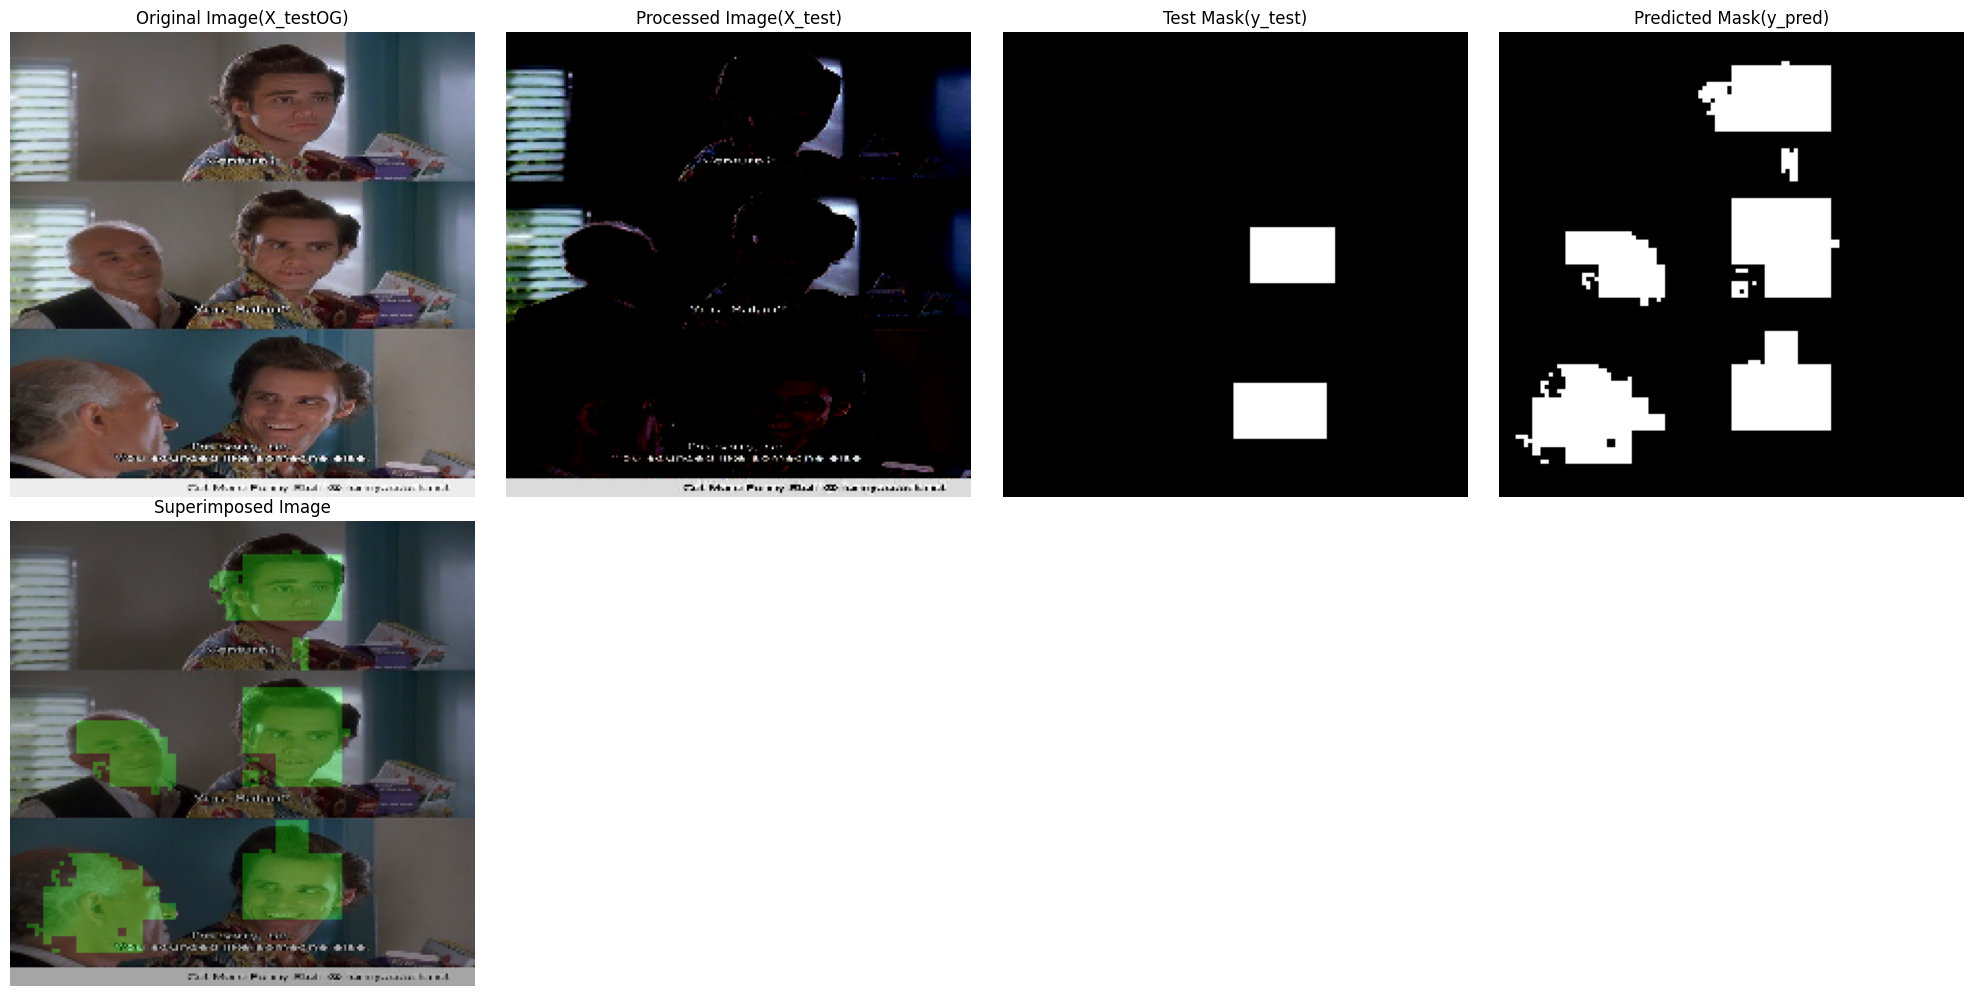

In [215]:
import numpy as np
import matplotlib.pyplot as plt

#Define function for merging image with masks
def superimpose_mask_on_image(original_image, prediction_mask, alpha=0.3):
    """
    Superimpose the prediction mask on the original image.

    :param original_image: numpy array of the original image
    :param prediction_mask: numpy array of the prediction mask
    :param alpha: transparency factor for the mask overlay
    :return: numpy array of the superimposed image
    """

    prediction_mask_resized = np.resize(prediction_mask, (original_image.shape[0], original_image.shape[1]))

    # Apply a colormap to the mask (e.g., green color)
    prediction_mask_colored = np.zeros_like(original_image)
    prediction_mask_colored[:, :, 0] = 0                              # Red channel
    prediction_mask_colored[:, :, 1] = prediction_mask_resized * 255  # Green channel
    prediction_mask_colored[:, :, 2] = 0                              # Blue channel

    # Superimpose the mask on the original image
    superimposed_image = (original_image * (1 - alpha) + prediction_mask_colored * alpha).astype(np.uint8)

    return superimposed_image

# Select the index of the image to visualize
index = 3

# Select the image and mask from the test data
test_imageOG = X_testOG[index]
test_image = X_test[index]
test_mask = y_test[index]

# Predict the mask for the test image using basic Model
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Convert the masks to binary values
test_mask = np.where(test_mask > 0.5, 1, 0)
predicted_mask = np.where(predicted_mask > 0.5, 1, 0)

# Superimpose the predicted mask on the original image
superimposed_image = superimpose_mask_on_image(test_imageOG, predicted_mask, alpha=0.3)

# Plot the original image, test mask, predicted mask, and superimposed image
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1: Original Image, Processed Image, Test Mask, Predicted Mask
axes[0, 0].imshow(test_imageOG)
axes[0, 0].set_title('Original Image(X_testOG)')
axes[0, 0].axis('off')

axes[0, 1].imshow(test_image)
axes[0, 1].set_title('Processed Image(X_test)')
axes[0, 1].axis('off')

axes[0, 2].imshow(test_mask, cmap='gray')
axes[0, 2].set_title('Test Mask(y_test)')
axes[0, 2].axis('off')

axes[0, 3].imshow(predicted_mask, cmap='gray')
axes[0, 3].set_title('Predicted Mask(y_pred)')
axes[0, 3].axis('off')

# Row 2: Superimposed Image
axes[1, 0].imshow(superimposed_image)
axes[1, 0].set_title('Superimposed Image')
axes[1, 0].axis('off')

# Hide empty subplots
axes[1, 1].axis('off')
axes[1, 2].axis('off')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()


## Part B

### Q.1. Read/import images from folder ‘training_images’

In [216]:

import os
from PIL import Image
#Function to load all images for given folder
def load_images_from_folder(folder):
    images = []
    filenames = []
    supported_formats = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
    for filename in os.listdir(folder):
        if filename.lower().endswith(supported_formats):
            img_path = os.path.join(folder, filename)
            try:
                with Image.open(img_path) as img:
                    images.append(np.array(img))
                    filenames.append(filename)
            except IOError as e:
                print(f"Error loading image {img_path}: {e}")
    return images, filenames


training_images, training_filenames = load_images_from_folder('/content/drive/My Drive/Colab/CV/training_images')
# Print the count of images loaded
print(f"Number of images loaded: {len(training_images)}")

Number of images loaded: 1091


### Q.2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images

Face detection & display images

In [217]:

import random
#Function to find face coordinates using OpenCV CascadeClassifier. Faces to be determined for all images
def detect_faces(image_list):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    detected_faces = []

    for img in image_list:
        # Ensure the image is in the correct format
        if img is None or not isinstance(img, np.ndarray):
            print("Invalid image")
            continue
        if len(img.shape) == 2 or img.shape[2] == 1:  # Grayscale image
            gray = img
        else:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        # Draw rectangles around detected faces
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        detected_faces.append(img)

    return detected_faces

#Function to display images with rectangles for faces
def display_images(images, titles=None, image_count=None, max_images_per_row=10):
    n_images = len(images)
    if image_count is None:
        image_count = n_images
    else:
        image_count = min(image_count, n_images)

    # Select random images if image_count is specified
    if image_count < n_images:
        random_indices = random.sample(range(n_images), image_count)
        images = [images[idx] for idx in random_indices]
        if titles:
            titles = [titles[idx] for idx in random_indices]

    n_rows = (image_count + max_images_per_row - 1) // max_images_per_row  # Calculate number of rows needed
    plt.figure(figsize=(20, n_rows * 5))

    for i in range(image_count):
        plt.subplot(n_rows, min(max_images_per_row, image_count), i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        if titles:
            plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [218]:
#Display few images with detected faces
detected_faces = detect_faces(training_images)

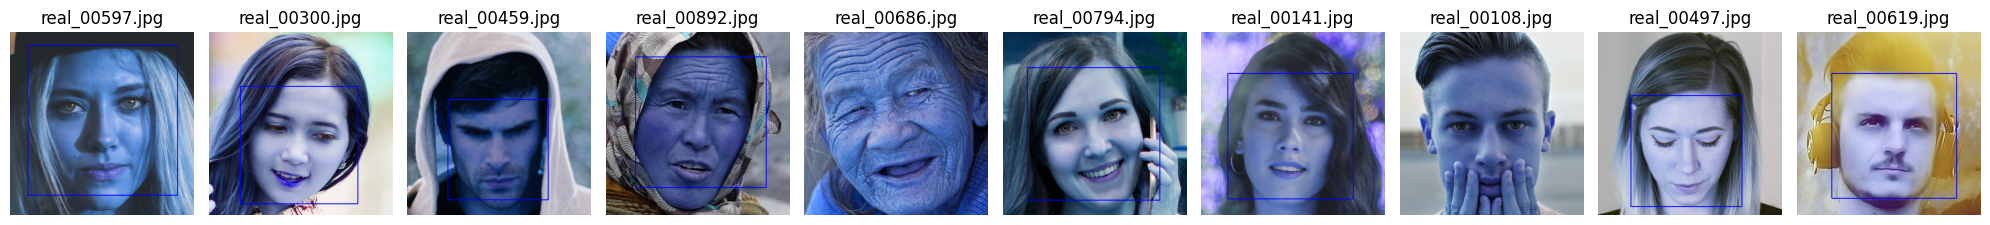

In [219]:
display_images(detected_faces, training_filenames, image_count=10)

### Q.3 From the same loop above, extract metadata of the faces and write into a DataFrame.

Metadata extraction

In [220]:
import pandas as pd
#Function to determine metadata using CascadeClassifier and store in dataframe
def get_faces_metadata(image_list, image_filenames):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    data = []

    for img, filename in zip(image_list, image_filenames):
        # Ensure the image is in the correct format
        if img is None or not isinstance(img, np.ndarray):
            print(f"Invalid image: {filename}")
            continue
        if len(img.shape) == 2 or img.shape[2] == 1:  # Grayscale image
            gray = img
        else:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        num_faces = len(faces)

        for (x, y, w, h) in faces:
            data.append({'image_name': filename, 'x': x, 'y': y, 'w': w, 'h': h, 'num_faces': num_faces})

    df = pd.DataFrame(data)
    return df

In [221]:
df_faces = get_faces_metadata(training_images, training_filenames)

# Print the first few records of the DataFrame
print(f"Shape of the DataFrame: {df_faces.shape}")
print(df_faces.head())

Shape of the DataFrame: (651, 6)
       image_name    x    y    w    h  num_faces
0  real_00993.jpg  183   83  377  377          1
1  real_01060.jpg   94  131  396  396          1
2  real_00983.jpg   99  102  448  448          1
3  real_01002.jpg   52  131  398  398          1
4  real_01064.jpg  101  143  415  415          1


### Q.4. Save the output Dataframe in .csv format

In [222]:
df_faces.to_csv('/content/drive/My Drive/Colab/CV/face_metadata.csv', index=False)
temp_df = pd.read_csv('/content/drive/My Drive/Colab/CV/face_metadata.csv')

# Print the shape of the DataFrame
print(f"Shape of the saved dataFrame: {temp_df.shape}")

Shape of the saved dataFrame: (651, 6)


# Part C

### Q.1. Unzip, read and Load data(‘PINS.zip’) into session.

Unzip images

In [310]:
# from google.colab import drive
import os
import zipfile

zip_file_path = '/content/drive/My Drive/Colab/CV/PINS.zip'
extract_path = '/content/drive/My Drive/Colab/CV/PINS/'
read_path = '/content/drive/My Drive/Colab/CV/PINS/PINS/'
# zip_file_path = 'C:/Users/prash/GL-AI-ML/Computer Vision/Project/PINS.zip'
# extract_path = 'C:/Users/prash/GL-AI-ML/Computer Vision/Project/PINS/'

In [311]:

def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted all files to: {extract_to}")

# Unzip the archive
unzip_file(zip_file_path, extract_path)

Extracted all files to: /content/drive/My Drive/Colab/CV/PINS/


Load images into session

In [312]:
from concurrent.futures import ThreadPoolExecutor, as_completed
#Function to load/resize image from path
def load_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Failed to load image at {img_path}")
        return None
    # Resize image if needed (optional, remove if resizing is not desired)
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    return np.array(img)

#Multithreading function for reading images from folder
def load_images_from_folder(folder, num_workers=8):
    images = []
    labels = []
    image_paths = []

    for subdir, _, files in os.walk(folder):
        for file in files:
            if file.endswith(('jpeg', 'jpg', 'png')):
                img_path = os.path.join(subdir, file)
                image_paths.append((img_path, os.path.basename(subdir)))

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_path = {executor.submit(load_image, img_path): (img_path, label) for img_path, label in image_paths}

        for future in as_completed(future_to_path):
            img_path, label = future_to_path[future]
            try:
                img = future.result()
                if img is not None:
                    images.append(img)
                    labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return images, labels


In [313]:
# read_path = 'C:/Users/prash/GL-AI-ML/Computer Vision/Project/PINS/PINS/PINS/'

images, labels = load_images_from_folder(read_path , num_workers=8)

print(f"Loaded {len(images)} images.")

Loaded 10770 images.


## Q.2. Write function to create metadata of the image

In [314]:
#Create class to get metadata for particular image
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

# base: The base directory where the dataset is located.
# name: The subdirectory for the specific identity.
# file: The image file name.

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

    def get_metadata(self):
      img_path = self.image_path()
      try:
          with Image.open(img_path) as img:
              width, height = img.size
              file_size = os.path.getsize(img_path)
              return {
                  'filename': self.file,
                  'width': width,
                  'height': height,
                  'file_size': file_size,
                  'path': img_path
              }
      except IOError as e:
          print(f"Error loading image {img_path}: {e}")
          return None

### Q.3. Write a loop to iterate through each and every image and create metadata for all the images.

In [315]:
#function to load metadata for each image in path
def load_metadata(path):
    metadata = []
    for person_name in os.listdir(path):
        person_dir = os.path.join(path, person_name)
        if os.path.isdir(person_dir):
            for f in os.listdir(person_dir):
                # Check file extension. Allow only jpg/jpeg files.
                ext = os.path.splitext(f)[1].lower()
                if ext in ['.jpg', '.jpeg']:
                    metadata.append(IdentityMetadata(path, person_name, f))
    return np.array(metadata)

In [316]:
# Load metadata for all images and save in variable
metadata = load_metadata(read_path)
print(metadata)

[/content/drive/My Drive/Colab/CV/PINS/PINS/pins_Aaron Paul/Aaron Paul0_262.jpg
 /content/drive/My Drive/Colab/CV/PINS/PINS/pins_Aaron Paul/Aaron Paul101_247.jpg
 /content/drive/My Drive/Colab/CV/PINS/PINS/pins_Aaron Paul/Aaron Paul101_248.jpg
 ... /content/drive/My Drive/Colab/CV/PINS/PINS/pins_zendaya/zendaya97.jpg
 /content/drive/My Drive/Colab/CV/PINS/PINS/pins_zendaya/zendaya98.jpg
 /content/drive/My Drive/Colab/CV/PINS/PINS/pins_zendaya/zendaya99.jpg]


Use metadat to load/display images

In [317]:
#Function to load and display images from metadata
def load_images(metadata, num_images):
    images = []
    for meta in metadata[:num_images]:
        img_path = meta.image_path()
        img = Image.open(img_path).convert('RGB')  # Convert to RGB
        images.append(np.array(img))
    return images

def display_images(images):
    # Calculate the grid size for displaying images
    num_images = len(images)
    cols = 3  # Number of columns
    rows = (num_images // cols) + (num_images % cols > 0)  # Number of rows needed

    plt.figure(figsize=(15, 5 * rows))

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
    plt.show()


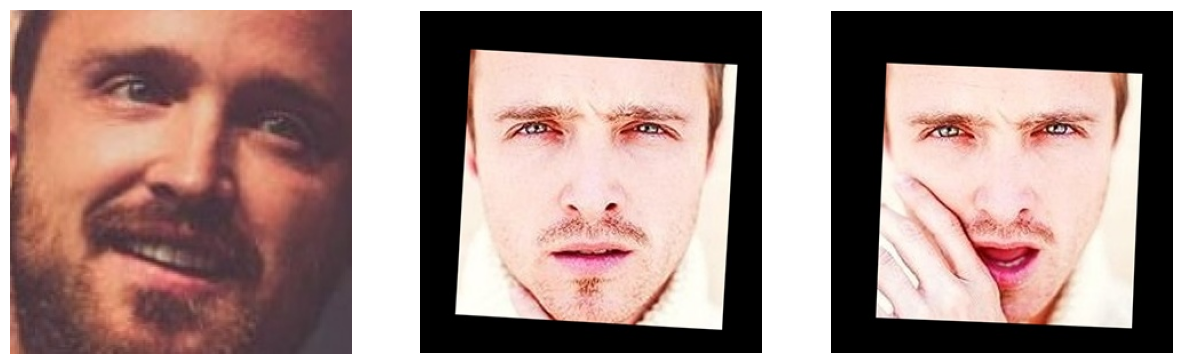

In [318]:
# print  metadata
num_images_to_load = 3
loaded_images = load_images(metadata, num_images_to_load)

# Display the loaded images
display_images(loaded_images)

## Q.4. Generate Embeddings vectors on the each face in the dataset

Define VGG vector generation function

In [319]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

Use function to generate VGG model

In [320]:
from tensorflow.keras.models import model_from_json
model = vgg_face()

# Load weights into the model
model.load_weights('/content/drive/My Drive/Colab/CV/vgg_face_weights.h5')

# Verify the model summary to ensure it's loaded correctly
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_39 (ZeroPad  (None, 226, 226, 3)       0         
 ding2D)                                                         
                                                                 
 conv2d_155 (Conv2D)         (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_40 (ZeroPad  (None, 226, 226, 64)      0         
 ding2D)                                                         
                                                                 
 conv2d_156 (Conv2D)         (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                      

In [321]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

Use sample image to check embedding vgg_face_descriptor size

In [322]:
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 0s 201ms/step
(2622,)


Generate embedded vectors for all images and store into variables

In [28]:
embeddings = np.zeros((len(metadata), 2622))

for i, m in enumerate(metadata):
# for i in range(500):
    try:
        # Load and preprocess image
        img = load_image(m.image_path())
        if img is None:
            raise ValueError(f"Image at path {m.image_path()} could not be loaded.")

        # Resize image and scale RGB values to the interval [0,1]
        img = cv2.resize(img, dsize=(224, 224))
        img = (img / 255.).astype(np.float32)

        # Obtain embedding vector for image
        embedding = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
        embeddings[i] = embedding

    except Exception as e:
        # Print error details
        print(f"Error processing image {i} ({m.image_path()}): {e}")
print("Embedding extraction completed.")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 76ms/step
Embedding extraction completed.


In [323]:
#Save embedded vectors for images into physical files for future use
np.save('/content/drive/My Drive/Colab/CV/embeddings.npy', embeddings)
# embeddings = np.load('/content/drive/My Drive/Colab/CV/embeddings.npy')


### Q.5. Build distance metrics for identifying the distance between two similar and dissimilar images

Function to find distance between two images (vectors)

In [324]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

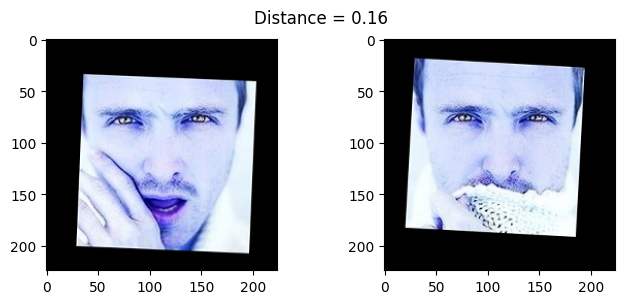

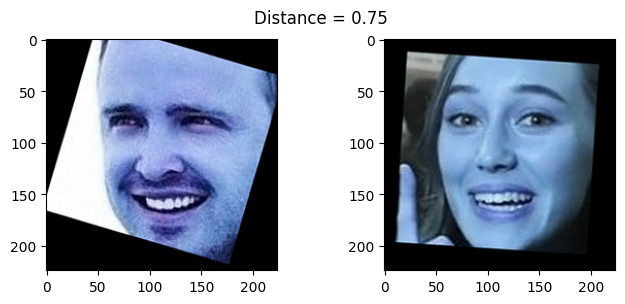

In [325]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(2, 3)
show_pair(5, 400)

## Q.6 Use PCA for dimensionality reduction

Data preprocessing

In [326]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

In [327]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder. transform(y_test)


In [328]:
# Standarizing features

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

PCA transformation

In [329]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)
X_train = pca.fit_transform(X_train)

X_test = pca.transform(X_test)

## Q.7. Build an SVM classifier in order to map each image to its right person

Model building for predicting faces

In [330]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', class_weight=None , C=100, gamma='auto')
svm.fit(X_train, y_train)

svm.score(X_test, y_test)

0.9615705931495405

Model testing / prediction

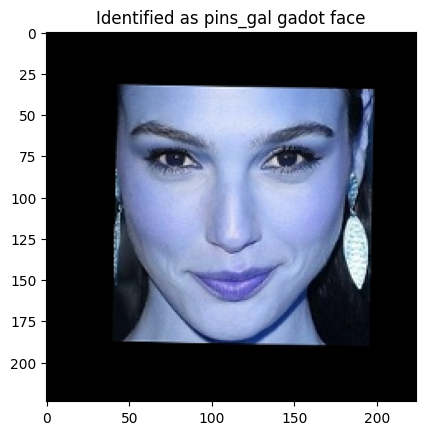

In [337]:
example_idx = 501

example_image = load_image(metadata[test_idx][example_idx].image_path())
plt.imshow(example_image)
example_prediction = svm.predict([X_test[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]
plt.imshow(example_image)

plt.title(f'Identified as {example_identity}');

## Q.8. Import and display the the test images

In [339]:
#Function to load images provided for test
def load_and_display_images(folder_path):
    # Get list of all files in the folder
    file_names = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Number of images
    num_images = len(file_names)

    # Calculate grid size
    cols = 3  # Number of columns in the grid
    rows = (num_images // cols) + (num_images % cols > 0)  # Number of rows needed

    # Create a figure for displaying images
    plt.figure(figsize=(15, 5 * rows))

    for i, file_name in enumerate(file_names):
        img_path = os.path.join(folder_path, file_name)
        image = cv2.imread(img_path)

        if image is not None:
            # Convert from BGR (OpenCV's default) to RGB (for display with matplotlib)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            plt.subplot(rows, cols, i + 1)
            plt.imshow(image_rgb)
            plt.axis('off')  # Hide axes
            plt.title(file_name)  # Display the filename as the title

    plt.show()

# Path to the Test folder
test_folder_path = '/content/drive/My Drive/Colab/CV/Test/'



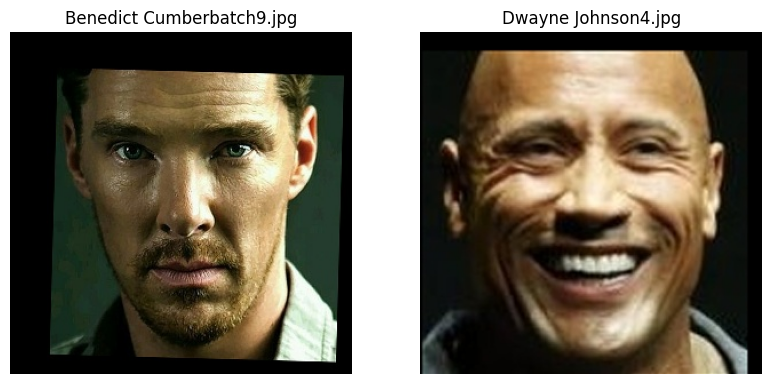

In [340]:
# Display images given in hint
load_and_display_images(test_folder_path)

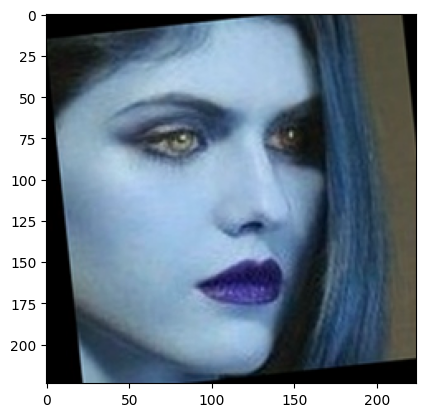

In [341]:
# Display image from testing (X_test) data

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
plt.imshow(example_image)

### Q.9 Use the trained SVM model to predict the face on both test images

##### Test model using different images given in problem statement '‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ '

1/1 [==============================] - 0s 26ms/step


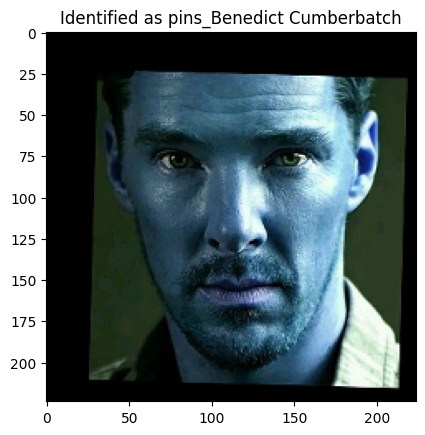

1/1 [==============================] - 0s 24ms/step


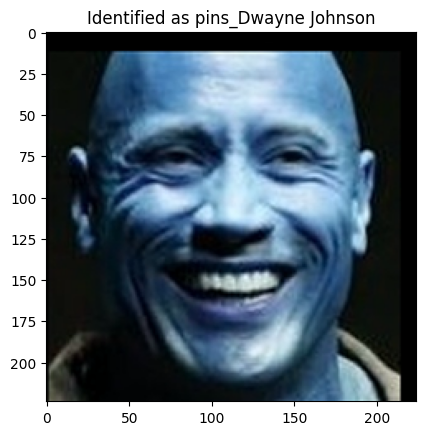

In [342]:
def predict_Person(image_rgb,sc,pca,vgg_face_descriptor):
    """
    Predict the class of the image using the pre-trained SVM model.
    """
    image_rgb = (image_rgb / 255.).astype(np.float32)
    image_rgb = cv2.resize(image_rgb, dsize = (224,224))

    # obtain embedding vector for image
    embed = vgg_face_descriptor.predict(np.expand_dims(image_rgb, axis=0))[0]

    embed_transform = sc.transform(embed.reshape(1, -1))
    embed_transform = pca.transform(embed_transform)

    # Perform prediction using SVC
    example_prediction = svm.predict(embed_transform)
    example_identity = encoder.inverse_transform(example_prediction)[0]

    return example_identity

test_image_paths = [
    '/content/drive/My Drive/Colab/CV/Test/Benedict Cumberbatch9.jpg',
    '/content/drive/My Drive/Colab/CV/Test/Dwayne Johnson4.jpg'
]

for image_path in test_image_paths:
  TestImg = load_image(image_path)
  Pred =  predict_Person(TestImg,sc,pca,vgg_face_descriptor)

  plt.imshow(TestImg)
  plt.title(f'Identified as {Pred}');
  plt.show()

##### Test model using Test images (X_test)

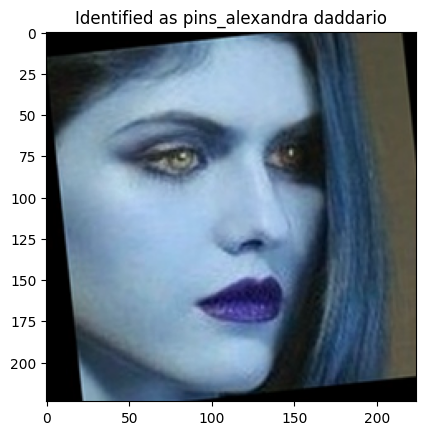

In [343]:
# Suppressing LabelEncoder warning

import warnings

# Suppressing LabelEncoder warning

warnings. filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svm.predict([X_test[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]
plt.imshow(example_image)

plt.title(f'Identified as {example_identity}');

**Observations**

* SVM Model Performance:
The SVM model achieved an impressive accuracy of 95% on the testing images, indicating its robustness and effectiveness in classifying faces based on the embeddings.
Generalization to Unseen Images:

* The model demonstrated its ability to generalize well by successfully predicting identities for images not included in the training or test datasets. This suggests that the model is not just memorizing the training data but learning meaningful features.
Compute Resources for Embedding Generation:

* Generating embedding vectors for all images requires substantial computational resources. This process can be resource-intensive, especially with large datasets, highlighting the need for efficient computation and storage strategies.

* Impact of PCA on Model Efficiency:
Principal Component Analysis (PCA) significantly reduced the dimensionality of the feature vectors, which helped decrease computational complexity and improve model performance. By transforming the features to a lower-dimensional space, PCA facilitated faster training and evaluation while maintaining high accuracy.